# Analysis of the results

This notebook investigates the results of running this analysis.

## Imports and hardcoded variables

In [1]:
import json
import os

import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl

from matplotlib import pyplot as plt
from pprint import pprint
from sphincter.data_preparation import load_prepared_data

INFERENCES_DIR = os.path.join("..", "inferences")
PLOTS_DIR = os.path.join("..", "plots")
ARVIZ_STYLE = "arviz-redish"

plt.style.use(ARVIZ_STYLE)

## Loading InferenceData objects

The results of the analysis are stored as [`InferenceData`](https://arviz-devs.github.io/arviz/api/generated/arviz.InferenceData.html#arviz.InferenceData) objects in json files. The next cell loads these files.

In [2]:
idatas = {
    d: az.InferenceData.from_zarr(os.path.join(INFERENCES_DIR, d, "idata"))
    for d in os.listdir(INFERENCES_DIR)
    if os.path.isdir(os.path.join(INFERENCES_DIR, d))
}
idatas_q1 = {k: v for k, v in idatas.items() if "q1" in k}
idatas_q2 = {k: v for k, v in idatas.items() if "q2" in k}
idatas["q2-final"]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> sample_stats_prior
	> observed_data

In [3]:
raw = pd.read_csv("../data/raw/data_sphincter_paper.csv")

# Plot measurements

In [4]:
q1_data = load_prepared_data("../data/prepared/q1")

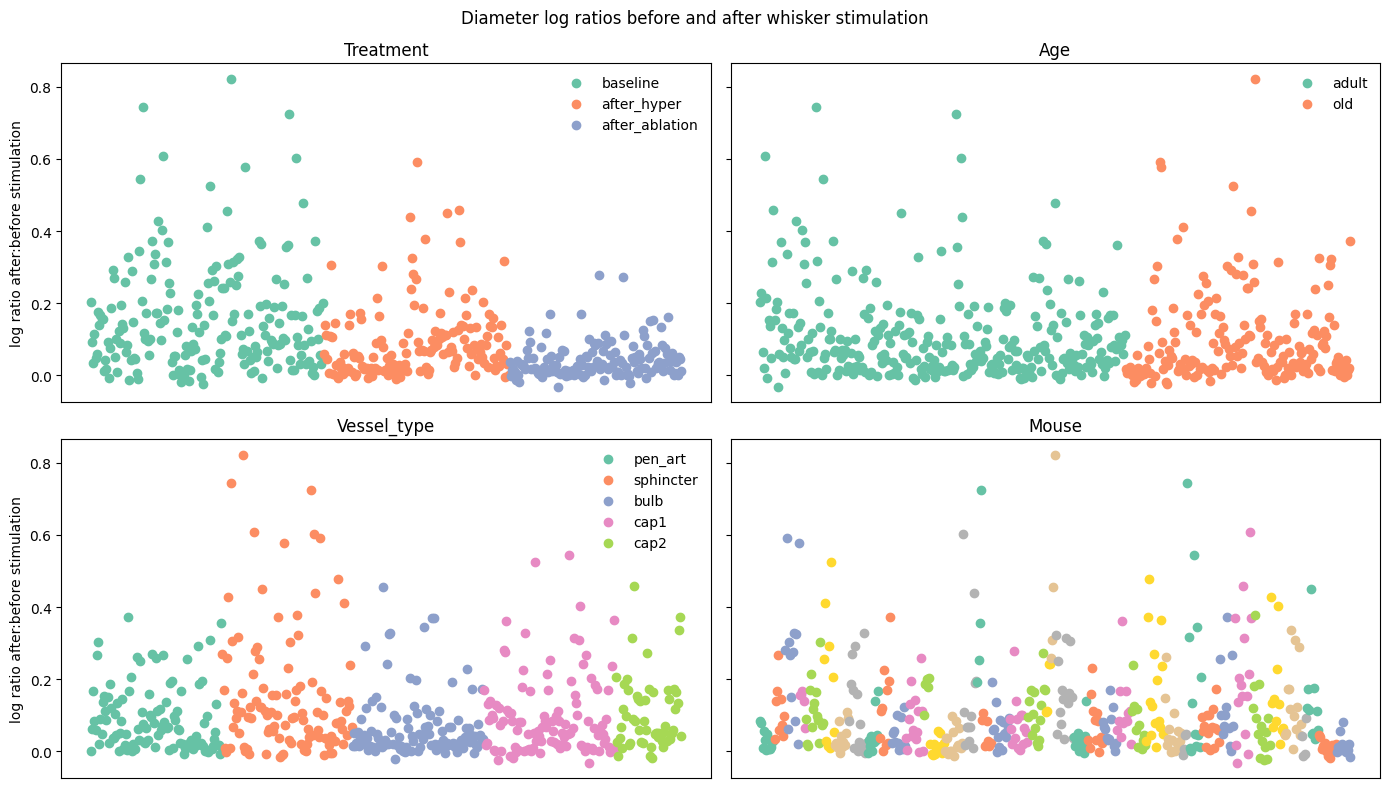

In [5]:
def plot_raw_data(ax, obs, **scatter_kwargs):
    x = np.linspace(*ax.get_xlim(), len(obs))
    ax.set_xticks([]);
    return ax.scatter(x, obs, **scatter_kwargs);

def get_colors(col, cmap):
    
    scalarMap = mpl.cm.ScalarMappable(norm=cNorm)
    return {cat: scalarMap.to_rgba(i) for i, cat in enumerate(col.cat.categories)}


def plot_raw_data_cat(ax, obs, catcol, cmap, weird_level=None, **scatter_kwargs):
    colors = list(cmap.colors)
    d = pd.DataFrame({"obs": obs, "cat": catcol}).sort_values("cat").assign(x=np.linspace(*ax.get_xlim(), len(obs)))
    scts = []
    if "label" in scatter_kwargs.keys():
        user_provided_label = True
        label = scatter_kwargs["label"]
        del scatter_kwargs["label"]
    else:
        user_provided_label = False
    for i, cat in enumerate(catcol.cat.categories):
        color = colors[i % len(colors)]
        y = d.loc[catcol == cat, "obs"]
        xcat = d.loc[y.index, "x"]
        label = label if user_provided_label else cat
        scts.append(ax.scatter(xcat, y, label=label, color=color, **scatter_kwargs))
        if weird_level is not None:
            for i, yi in y.items():
                if yi > weird_level:
                    ax.text(xcat.loc[i], yi, "?")
    return scts
    
obs = q1_data.measurements["diam_log_ratio"]
cmap = mpl.colormaps["Set2"]

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = q1_data.measurements[col]
    plot_raw_data_cat(ax, obs, catcol, cmap=cmap, weird_level=1.0)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("log ratio after:before stimulation");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
f.suptitle("Diameter log ratios before and after whisker stimulation");
f.tight_layout()

f.savefig(os.path.join(PLOTS_DIR, "whisker-measurements-faceted.png"), bbox_inches="tight")

In [6]:
q1_data.measurements.sort_values("diam_log_ratio", ascending=False).head(10)

,age,mouse,vessel_type,treatment,pressure_d,diam_before,diam_after,diam_change,diam_log_ratio,diam_rel_change
1398,old,170321,sphincter,baseline,45.931747,2.883007,6.561974,3.678967,0.822458,1.276087
257,adult,220920,sphincter,baseline,57.342675,1.292246,2.716551,1.424305,0.742981,1.102193
790,adult,130520,sphincter,baseline,39.711475,2.875097,5.935412,3.060316,0.724850,1.064422
65,adult,260520,sphincter,baseline,56.003344,2.743920,5.040000,2.296080,0.608019,0.836788
293,adult,121020,sphincter,baseline,57.342675,2.027385,3.707182,1.679797,0.603525,0.828553
1090,old,20920,sphincter,after_hyper,54.881456,3.505669,6.338039,2.832369,0.592188,0.807940
1078,old,20920,sphincter,baseline,59.925212,5.798635,10.344819,4.546184,0.578863,0.784009
259,adult,220920,cap1,baseline,57.492351,1.877116,3.232112,1.354997,0.543399,0.721850
984,old,50520,cap1,baseline,43.182158,2.444732,4.134000,1.689268,0.525310,0.690983
822,adult,210521,sphincter,baseline,59.824516,5.636729,9.092732,3.456002,0.478171,0.613122


## Comparing in and out of sample log likelihoods

This cell uses arviz's [`compare`](https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html) function to calculate the approximate leave-one-out expected posterior log predictive density for each inference.

It then calculates the average posterior in and out of sample log likelihoods.

In [7]:
idatas_to_compare = {k: v for k, v in idatas.items() if "q1" in k and "log_likelihood" in v.groups()}
if len(idatas_to_compare.keys()) == 1:
    validation = az.loo(next(iter(idatas_to_compare.values())))
elif len(idatas_to_compare.keys()) > 1:
    validation = az.compare(idatas_to_compare)
display(validation)

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
q1-ind,0,380.514702,184.893842,0.000000,0.820762,38.352126,0.000000,False,log
q1-flat,1,209.681103,809.059186,170.833599,0.179238,33.567250,25.240498,True,log


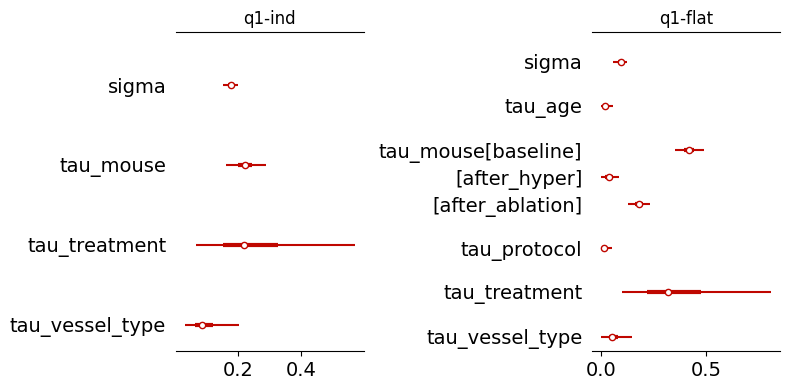

In [8]:
f, axes = plt.subplots(1, 2, figsize=[8, 4])
for (name, idata), ax in zip(idatas_q1.items(), axes):
    az.plot_forest(
        idata,
        var_names=["sigma", "tau"],
        filter_vars="like",
        combined=True,
        ax=ax
    );
    ax.set_title(name)
plt.tight_layout()

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['a_vtm'] have not been found and will be ignored
  warnings.warn(
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['a_vtm'] have not been found and will be ignored
  warnings.warn(


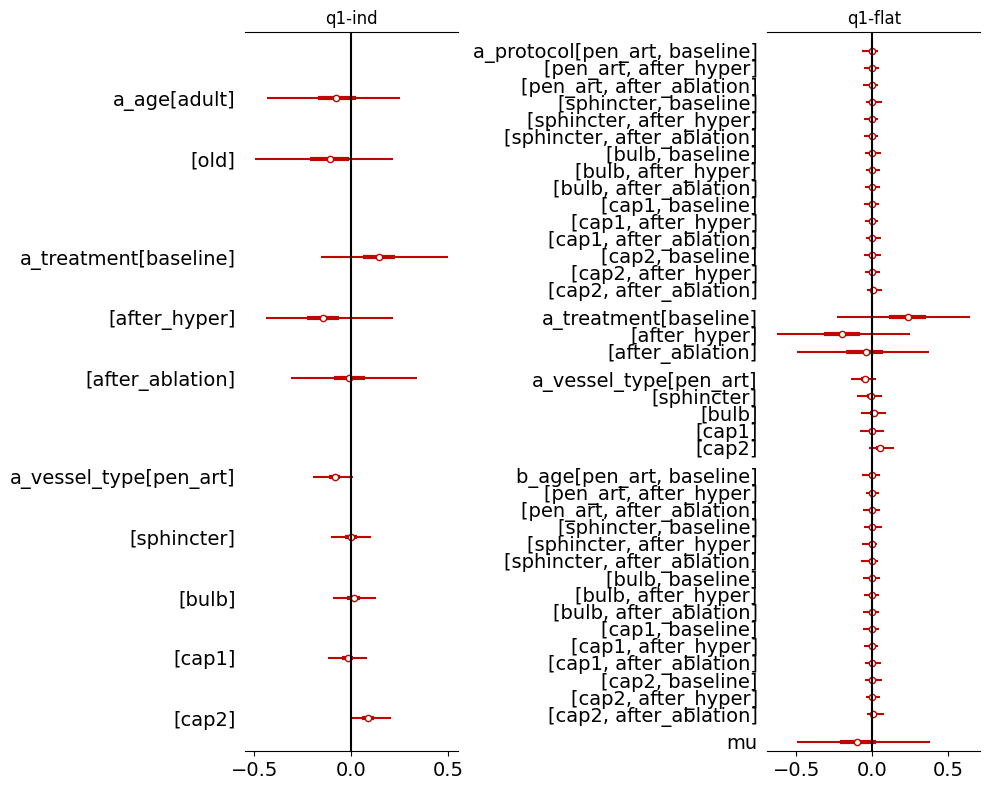

In [9]:
f, axes = plt.subplots(1, 2, figsize=[10, 8])
for (name, idata), ax in zip(idatas_q1.items(), axes):
    az.plot_forest(
        idata,
        var_names=["~a_mouse", "~_z", "~tau", "~nu", "~sigma", "~a_vtm"], 
        filter_vars="like",
        combined=True,
        ax=ax
    );
    ax.set_title(name)
    ax.axvline(0, color="black")
plt.tight_layout()

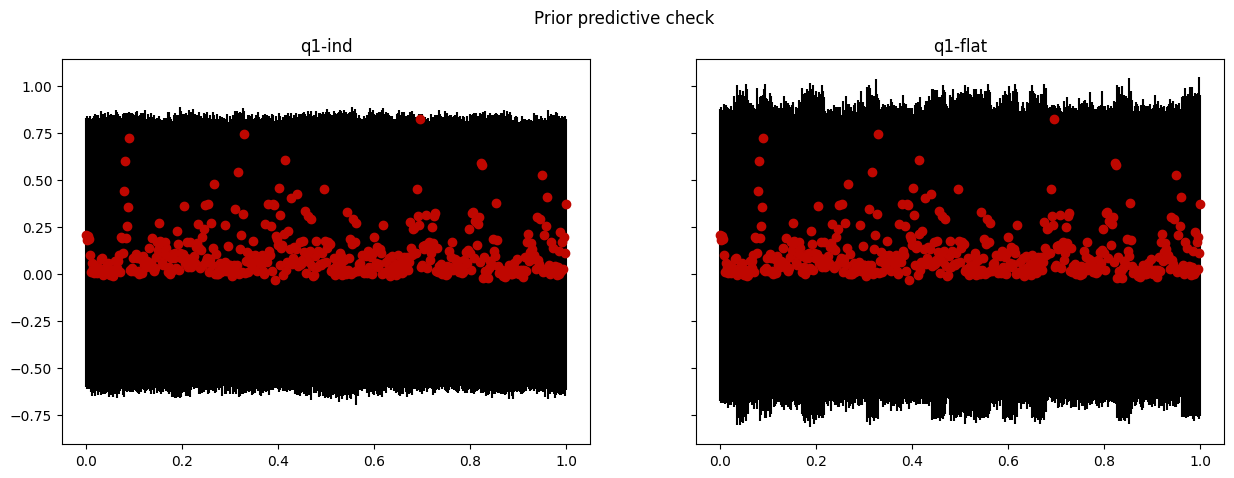

In [10]:
f, axes = plt.subplots(1, len(idatas_q1.values()), figsize=[15, 5], sharey=True)
f.suptitle("Prior predictive check")

for ax, (name, idata) in zip(axes, idatas_q1.items()):
    yobs = xr.DataArray(
        idata.observed_data["y"].values, 
        coords={"observation": idata.prior_predictive.coords["observation"]}
    )
    yrep = idata.prior_predictive["yrep"]
    qs = yrep.quantile([0.025, 0.975], dim=["chain", "draw"])
    x = np.linspace(*ax.get_xlim(), len(yobs))
    ax.scatter(x, yobs);
    ax.vlines(x, qs.sel(quantile=0.025), qs.sel(quantile=0.975), color="black", zorder=-1);
    ax.set_title(name);
f.savefig(os.path.join(PLOTS_DIR, "whisker-prior-check.png"), bbox_inches="tight")

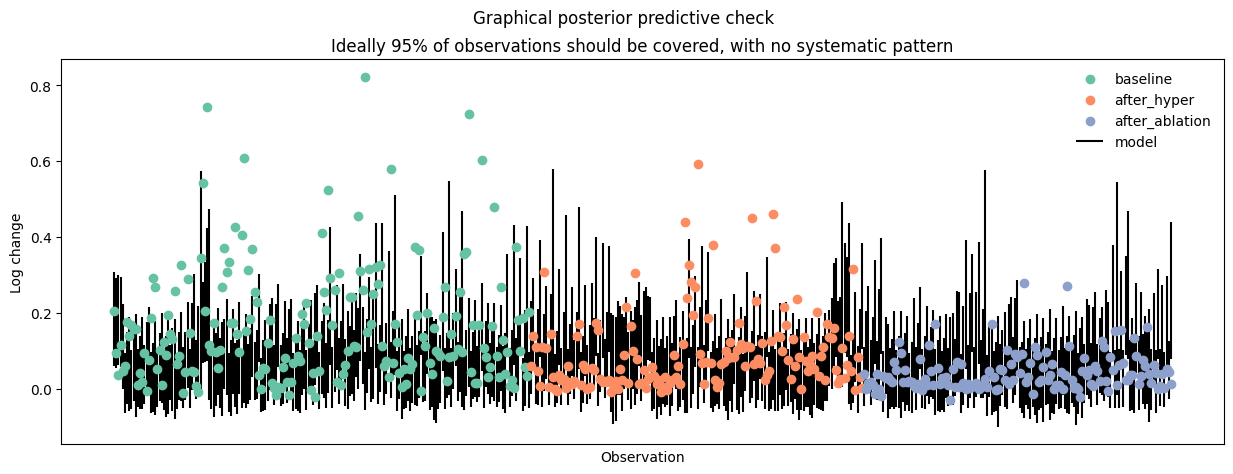

In [11]:
f, ax = plt.subplots(figsize=[15, 5])

yobs = pd.Series(xr.DataArray(
    idatas["q1-flat"].observed_data["y"].values, 
    coords={"observation": idatas["q1-flat"].posterior_predictive.coords["observation"]}
).values, index=q1_data.measurements.index)
yrep = idatas["q1-flat"].posterior_predictive["yrep"]
qs = yrep.quantile([0.025, 0.975], dim=["chain", "draw"])
x = np.linspace(*ax.get_xlim(), len(yobs))
plot_raw_data_cat(ax, yobs, q1_data.measurements["treatment"], cmap=cmap)
ax.vlines(x, qs.sel(quantile=0.025), qs.sel(quantile=0.975), color="black", zorder=-1, label="model");
ax.set_xticks([])
ax.legend(frameon=False);
ax.set(
    title="Ideally 95% of observations should be covered, with no systematic pattern",
    ylabel="Log change",
    xlabel="Observation"
);
f.suptitle("Graphical posterior predictive check");
f.savefig(os.path.join(PLOTS_DIR, "whisker-posterior-check.png"), bbox_inches="tight")

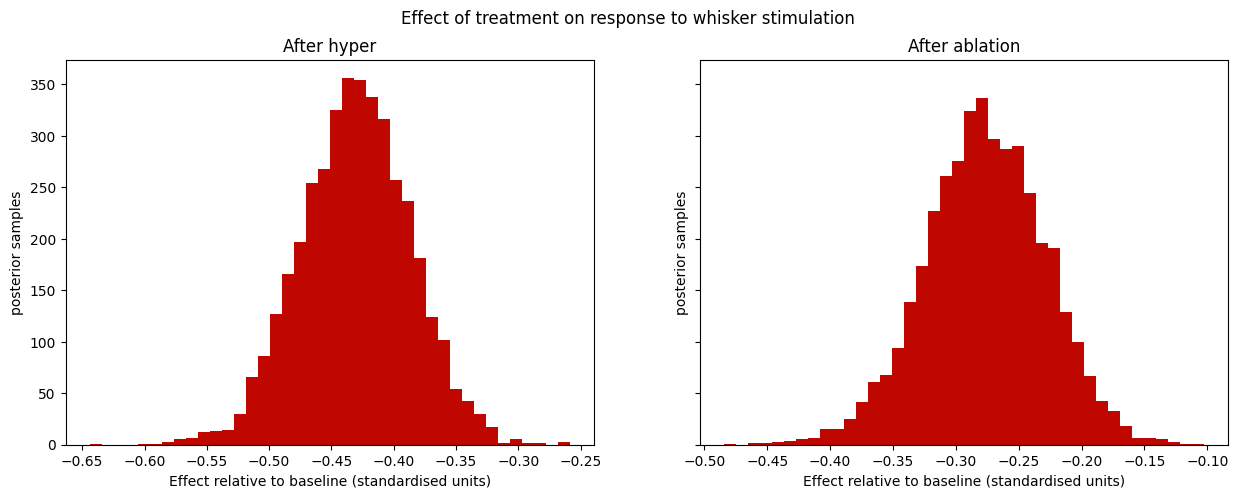

In [12]:
diff = idatas["q1-flat"].posterior["a_treatment"] - idatas["q1-flat"].posterior["a_treatment"].sel(treatment="baseline")

f, axes = plt.subplots(1, 2, figsize=[15, 5], sharey=True)
f.suptitle("Effect of treatment on response to whisker stimulation")
for treatment, ax in zip(["after_hyper", "after_ablation"], axes):
    ax.set(
        title=f"{treatment.capitalize().replace('_', ' ')}",
        ylabel="posterior samples",
        xlabel="Effect relative to baseline (standardised units)"
    )
    ax.hist(diff.sel(treatment=treatment).values.flatten(), bins=40)
f.savefig(os.path.join(PLOTS_DIR, "whisker-treatment-effects.png"), bbox_inches="tight")

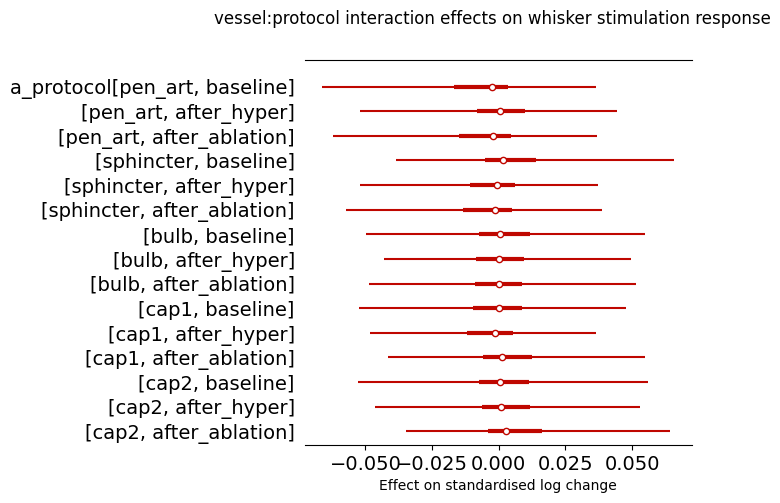

In [13]:
f, ax = plt.subplots(figsize=[5, 5])

f.suptitle("vessel:protocol interaction effects on whisker stimulation response")
az.plot_forest(
        idatas["q1-flat"],
        var_names="a_protocol",
        combined=True,
        ax=ax
    );
ax.set(
    title="",
    xlabel="Effect on standardised log change",
);
f.savefig(os.path.join(PLOTS_DIR, "whisker-protocol-effects.png"), bbox_inches="tight")

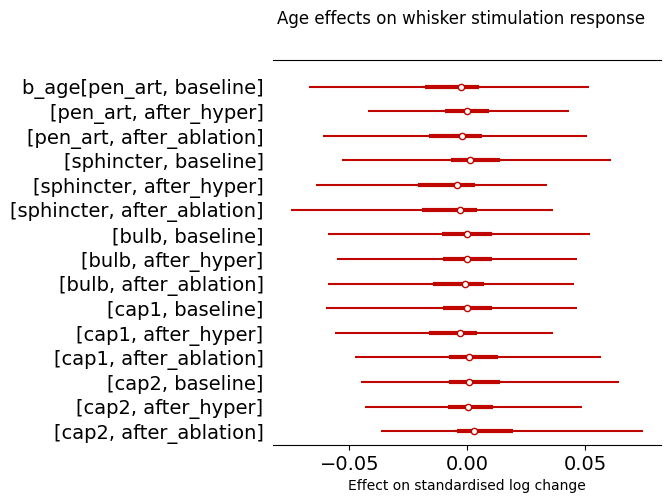

In [14]:
f, ax = plt.subplots(figsize=[5, 5])

f.suptitle("Age effects on whisker stimulation response")
az.plot_forest(
        idatas["q1-flat"],
        var_names="b_age",
        combined=True,
        ax=ax
    );
ax.set(
    title="",
    xlabel="Effect on standardised log change",
);
f.savefig(os.path.join(PLOTS_DIR, "whisker-age-effects.png"), bbox_inches="tight")

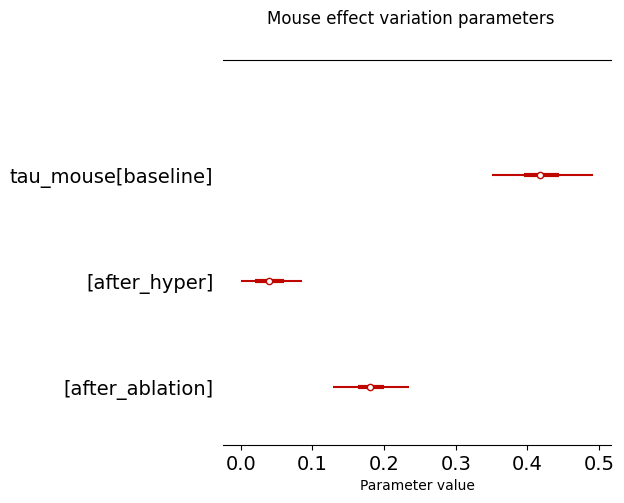

In [15]:
f, ax = plt.subplots(figsize=[5, 5])

f.suptitle("Mouse effect variation parameters")
az.plot_forest(
        idatas["q1-flat"],
        var_names="tau_mouse",
        combined=True,
        ax=ax
    );
ax.set(
    title="",
    xlabel="Parameter value",
);
f.savefig(os.path.join(PLOTS_DIR, "whisker-tau-mouse.png"), bbox_inches="tight")

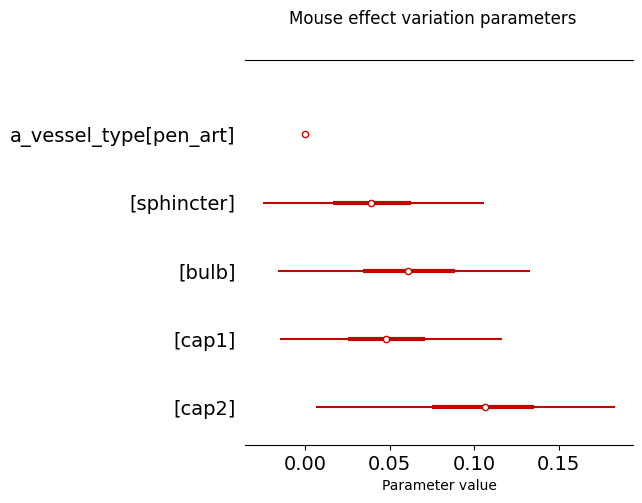

In [16]:
diff = idatas["q1-flat"].posterior["a_vessel_type"] - idatas["q1-flat"].posterior["a_vessel_type"].sel(vessel_type="pen_art")

f, ax = plt.subplots(figsize=[5, 5])

f.suptitle("Mouse effect variation parameters")
az.plot_forest(
        diff,
        var_names="a_vessel_type",
        combined=True,
        ax=ax
    );
ax.set(
    title="",
    xlabel="Parameter value",
);
f.savefig(os.path.join(PLOTS_DIR, "whisker-vessel-type-effects.png"), bbox_inches="tight")

# Q2

In [17]:
q2_data = load_prepared_data("../data/prepared/q2")

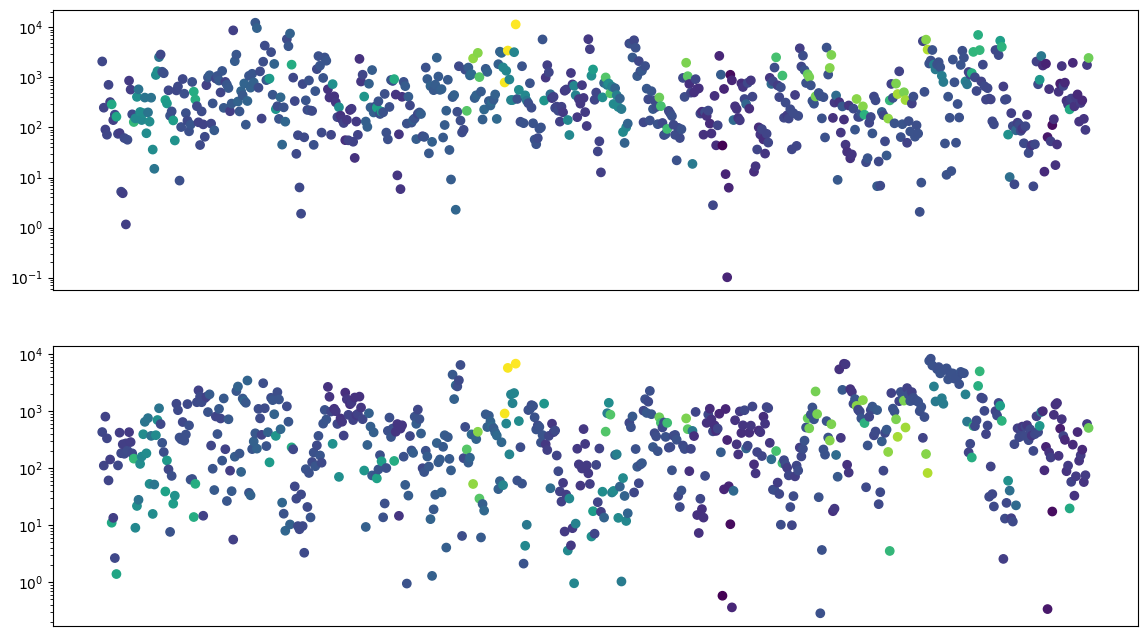

In [18]:
cmap = mpl.colormaps["viridis"]

f, axes = plt.subplots(2, 1, figsize=[14, 8])
axes = axes.ravel()
for ax, col in zip(axes, ["pd1", "pc1"]):
    obs = q2_data.measurements[col]
    plot_raw_data(ax, obs, c=q2_data.measurements["pressure_d"], cmap=cmap)
    ax.semilogy()

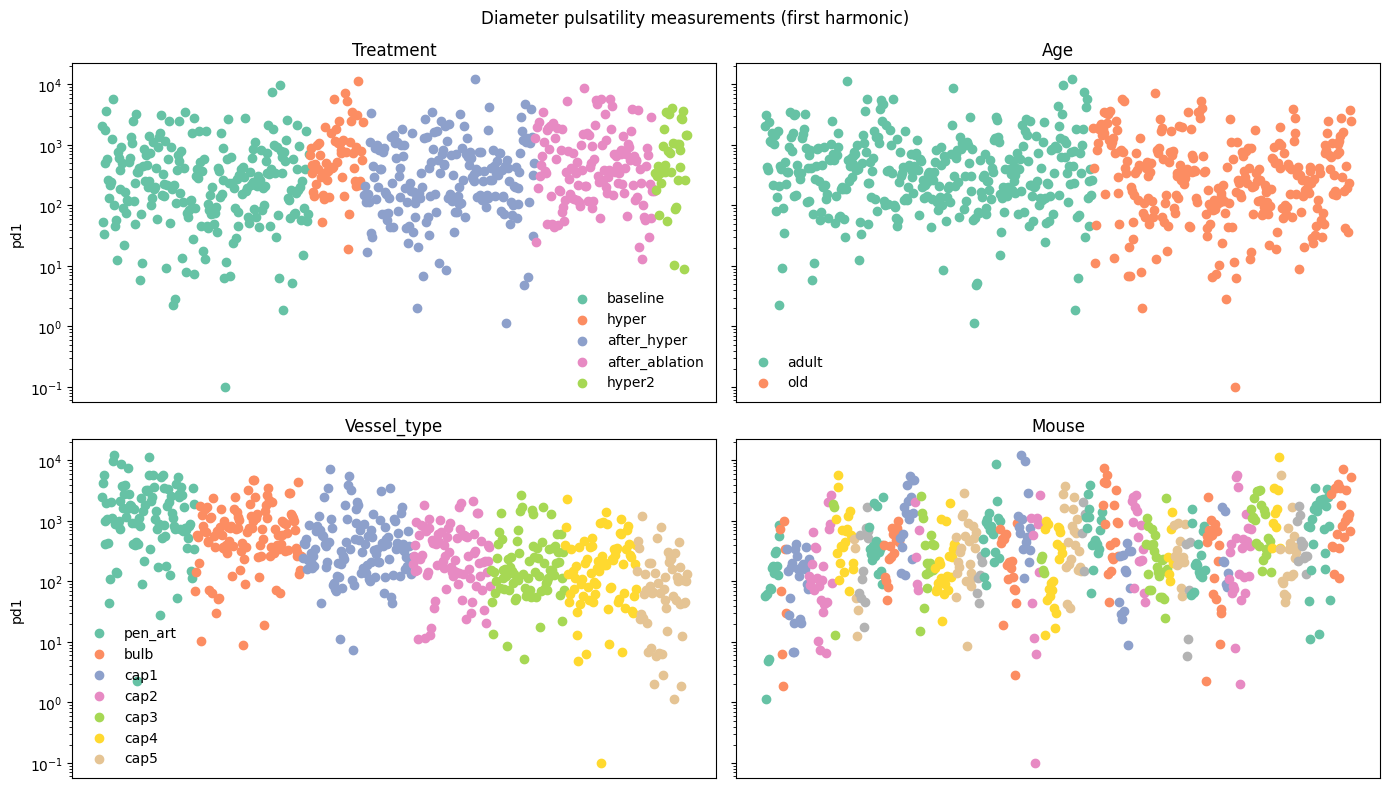

In [30]:
obs = q2_data.measurements["pd1"]
cmap = mpl.colormaps["Set2"]

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = q2_data.measurements[col]
    sct = plot_raw_data_cat(ax, obs, catcol, cmap)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("pd1");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
    ax.semilogy()
f.suptitle("Diameter pulsatility measurements (first harmonic)");
f.tight_layout()
f.savefig(os.path.join(PLOTS_DIR, "pulsatility-diameter-measurements.png"), bbox_inches="tight")

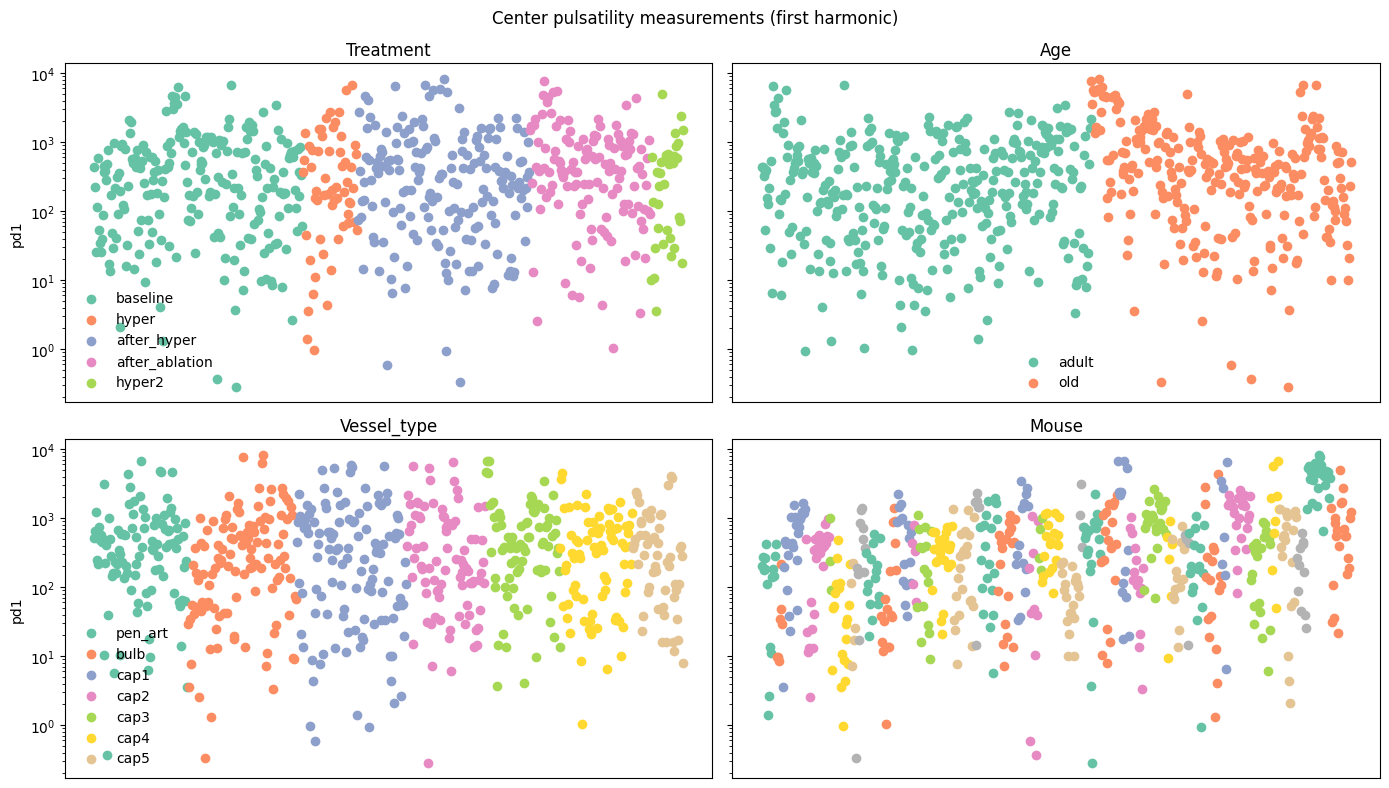

In [31]:
obs = q2_data.measurements["pc1"]
cmap = mpl.colormaps["Set2"]

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    catcol = q2_data.measurements[col]
    sct = plot_raw_data_cat(ax, obs, catcol, cmap)
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel("pd1");
    ax.set_xticks([])
    ax.set_title(col.capitalize())
    ax.semilogy()
f.suptitle("Center pulsatility measurements (first harmonic)");
f.tight_layout()
f.savefig(os.path.join(PLOTS_DIR, "pulsatility-center-measurements.png"), bbox_inches="tight")

In [21]:
az.compare({
    n: idatas["q2-" + n] for n in ["basic", "big", "final"]
})

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/tedgro/

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
final,0,-822.381918,65.732336,0.000000,0.640900,57.676171,0.000000,True,log
big,1,-830.965870,103.923892,8.583952,0.319941,57.749926,8.435795,True,log
basic,2,-844.979831,39.216202,22.597913,0.039159,59.247354,8.873060,True,log


In [36]:
k = az.loo(idatas["q2-final"], pointwise=True).pareto_k
q2_data.measurements.assign(k=k).loc[lambda df: df["k"] > 0.7].sort_values("k")

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,age,mouse,vessel_type,treatment,pd1,pd2,pd3,pd_sum,pd_ratio,pc1,pc2,pc3,pc_sum,pc_ratio,pressure_d,k
1368,old,160421,cap1,baseline,589.632003,62.200819,NaN,651.832822,0.095424,42.495003,15.622701,NaN,58.117704,0.268811,40.390138,0.706214
532,adult,110321,cap2,after_hyper,193.690989,20.227587,NaN,213.918576,0.094557,392.901671,12.806522,NaN,405.708193,0.031566,88.099531,0.716558
1341,old,310820,pen_art,hyper,5429.696313,613.301493,32.801804,6075.799611,0.100942,1239.185533,61.053874,2.034897,1302.274304,0.046882,97.877311,0.739186
1344,old,310820,cap1,hyper,7088.515141,841.943511,23.613055,7954.071707,0.105851,2760.463521,155.880979,5.152706,2921.497206,0.053357,106.387749,0.746933
1364,old,310820,cap1,hyper2,3525.793170,435.811268,83.918575,4045.523012,0.107727,4977.674050,277.019483,17.264509,5271.958042,0.052546,110.479850,0.798424
1172,old,200820,cap1,hyper2,263.931789,20.817774,NaN,284.749563,0.073109,2354.159031,291.221511,NaN,2645.380542,0.110087,61.128544,0.844845
896,adult,280521,cap1,hyper,3454.780118,140.137703,5.856412,3600.774233,0.038919,5713.435274,373.958664,0.689467,6088.083405,0.061425,152.759952,0.938444
893,adult,280521,pen_art,hyper,11506.184790,791.667295,NaN,12297.852086,0.064374,6781.397308,305.029899,NaN,7086.427207,0.043044,153.899488,0.971926


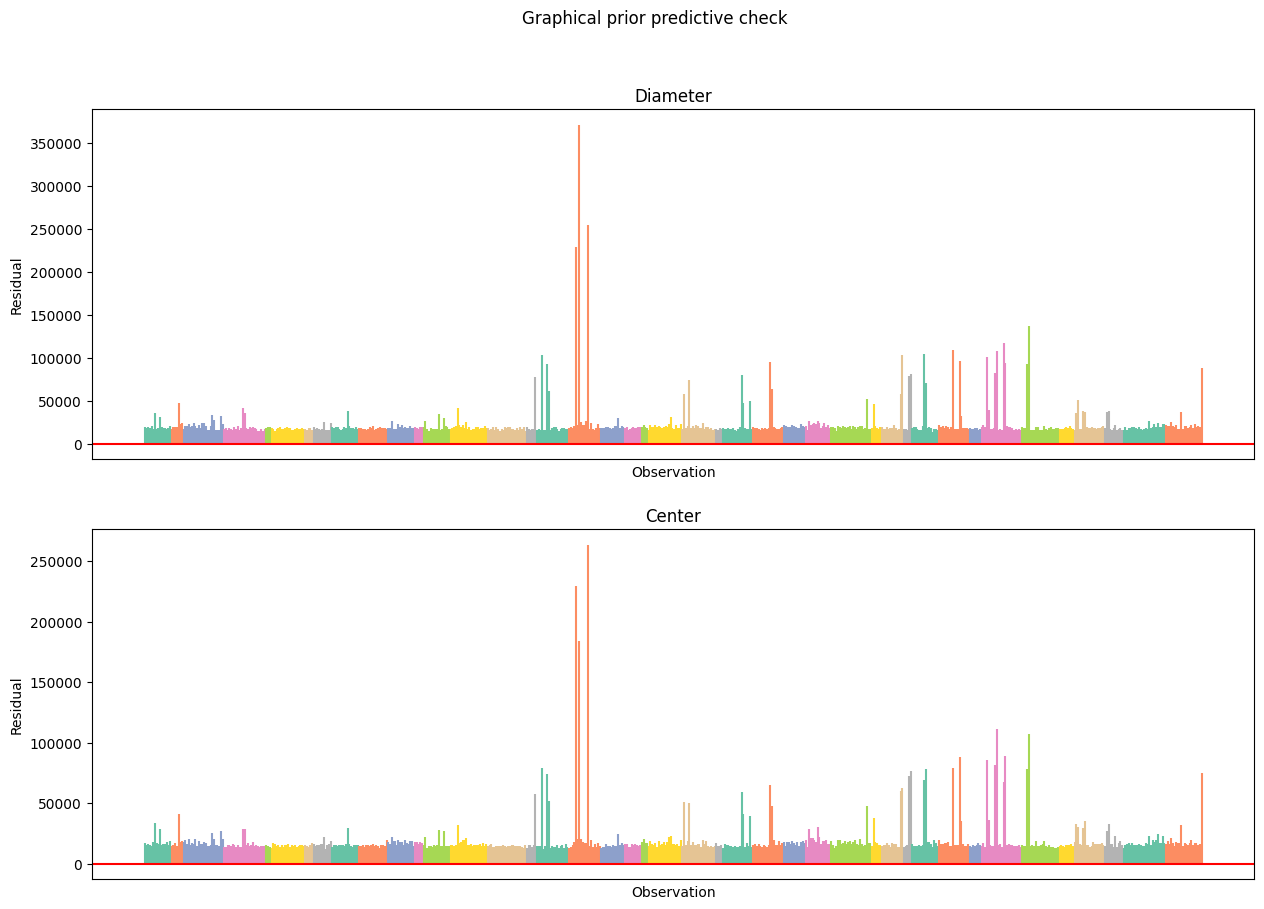

In [22]:
f, axes = plt.subplots(2, 1, figsize=[15, 10])

idata = idatas["q2-final"]
catcol = "mouse"
cmap = mpl.colormaps["Set2"]


m = q2_data.measurements.sort_values(catcol)

for ax, measurement_type in zip(axes, ["diameter", "center"]):
    colors = list(cmap.colors)
    yobs = idata.observed_data["y"].sel(measurement_type=measurement_type).values
    yrep = idata.prior_predictive["yrep"].sel(measurement_type=measurement_type)
    qs = (yrep).quantile([0.025, 0.975], dim=["chain", "draw"]).to_series().unstack("quantile")
    qs.index = m.index
    x = pd.Series(np.linspace(*ax.get_xlim(), len(yobs)), index=m.index)
    vls = []
    for i, cat in enumerate(m[catcol].cat.categories):
        color = colors[i % len(colors)]
        ix = m.query(f"{catcol} == {cat}").index
        xcat = x.loc[ix]
        vls.append(ax.vlines(x.loc[ix], qs.loc[ix, 0.025], qs.loc[ix, 0.975], label=cat, color=color))
    ax.axhline(0, color="r", label="y=0")
    ax.set_xticks([])
    ax.set(
        title=measurement_type.capitalize(),
        ylabel="Residual",
        xlabel="Observation"
    );
    # if ax == axes[0]:
        # ax.legend(frameon=False)


# f.legend(frameon=False, ncol=6, bbox_to_anchor=[0.7, 0.95]);
f.suptitle("Graphical prior predictive check");
f.savefig(os.path.join(PLOTS_DIR, "pulsatility-prior-check.png"), bbox_inches="tight")

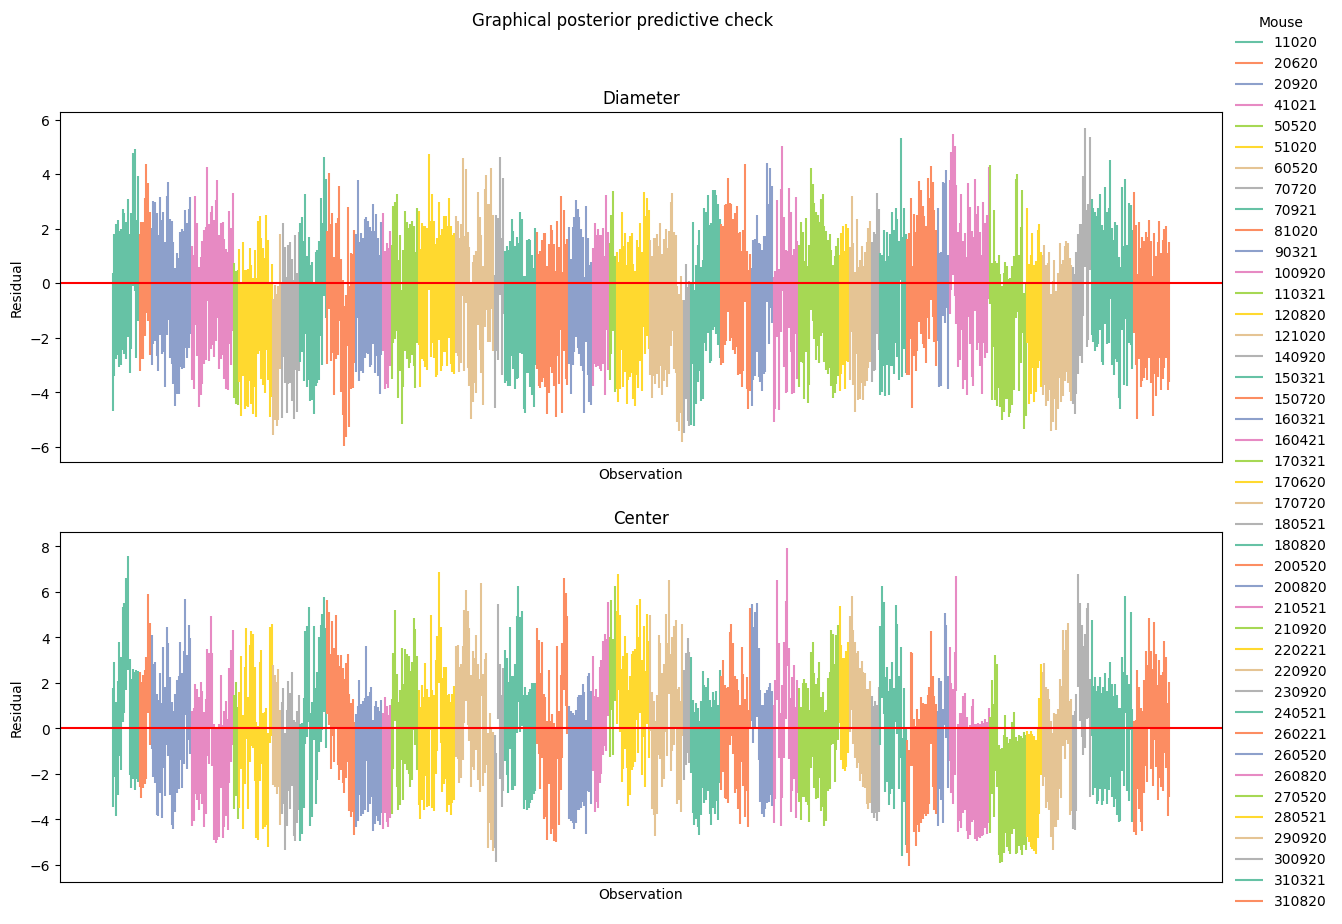

In [23]:
f, axes = plt.subplots(2, 1, figsize=[15, 10])

idata = idatas["q2-final"]
catcol = "mouse"
cmap = mpl.colormaps["Set2"]


m = q2_data.measurements.sort_values(catcol)

for ax, measurement_type in zip(axes, ["diameter", "center"]):
    colors = list(cmap.colors)
    yobs = idata.observed_data["y"].sel(measurement_type=measurement_type).values
    yrep = idata.posterior_predictive["yrep"].sel(measurement_type=measurement_type)
    qs = np.log(yrep / yobs).quantile([0.025, 0.975], dim=["chain", "draw"]).to_series().unstack("quantile")
    qs.index = m.index
    x = pd.Series(np.linspace(*ax.get_xlim(), len(yobs)), index=m.index)
    vls = []
    for i, cat in enumerate(m[catcol].cat.categories):
        color = colors[i % len(colors)]
        qstring = cat if catcol == "mouse" else f"'{cat}'"
        ix = m.query(f"{catcol} == {qstring}").index
        xcat = x.loc[ix]
        vls.append(ax.vlines(x.loc[ix], qs.loc[ix, 0.025], qs.loc[ix, 0.975], label=cat, color=color))
    ax.axhline(0, color="r")
    ax.set_xticks([])
    ax.set(
        title=measurement_type.capitalize(),
        ylabel="Residual",
        xlabel="Observation"
    );
    if ax == axes[0]:
        ax.legend(frameon=False, title=catcol.capitalize(), loc="center left", bbox_to_anchor=[1,0])


# f.legend(frameon=False, ncol=6, bbox_to_anchor=[0.7, 0.95]);
f.suptitle("Graphical posterior predictive check");
f.savefig(os.path.join(PLOTS_DIR, "pulsatility-posterior-check.png"), bbox_inches="tight")

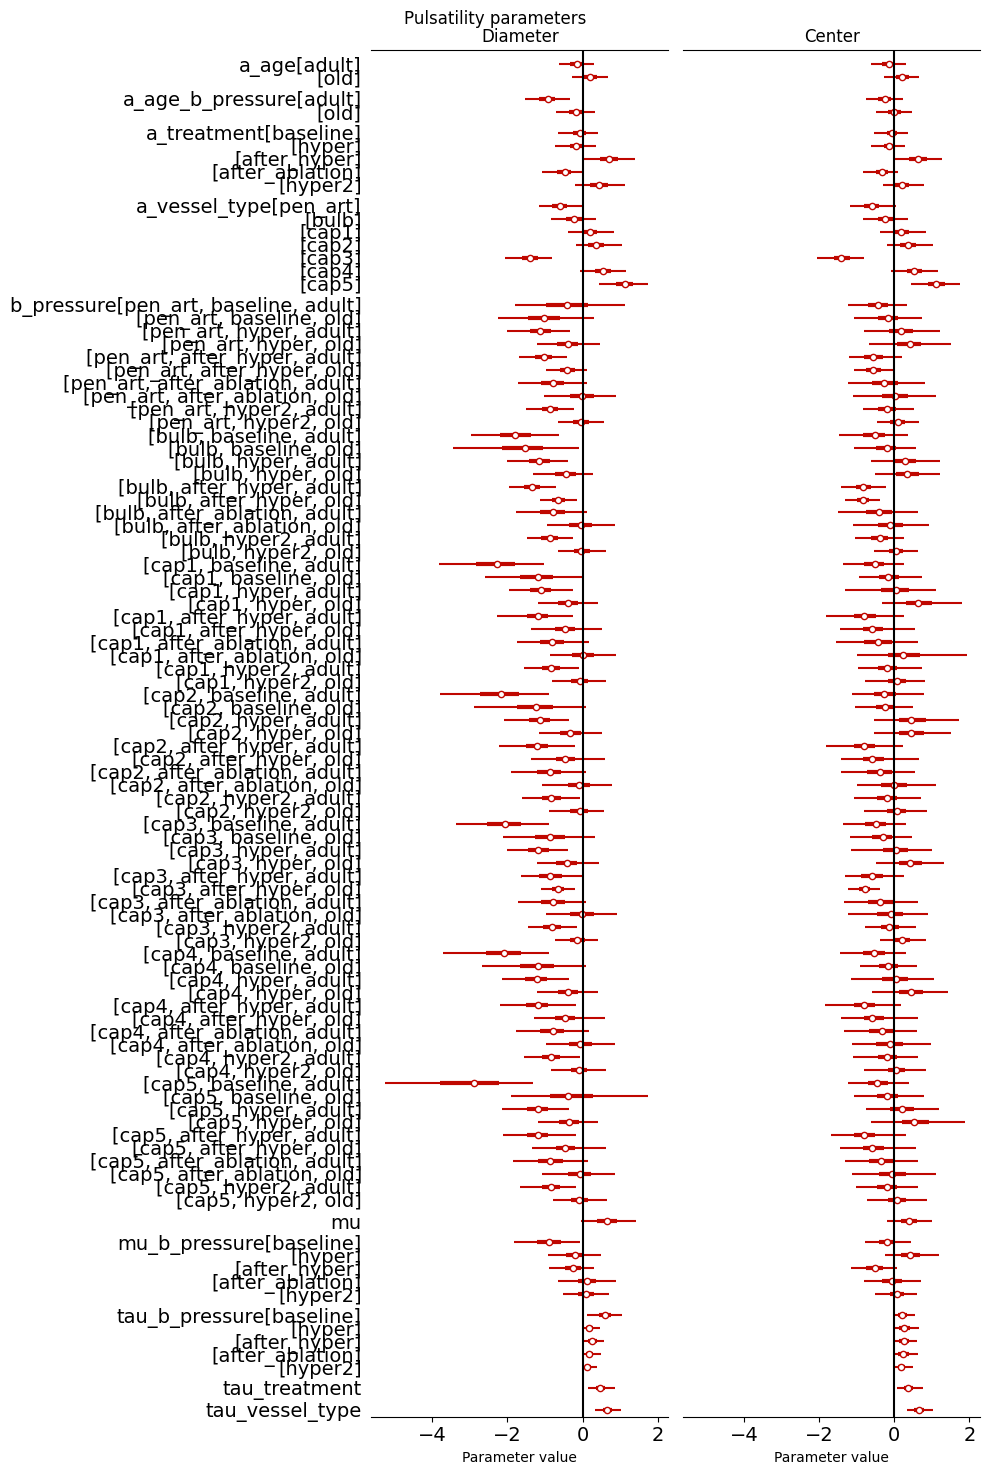

In [24]:
idata = idatas["q2-final"]

f, axes = plt.subplots(1, 2, figsize=[10, 15], sharex=True)

f.suptitle("Pulsatility parameters")
for ax, mt in zip(axes, idata.posterior.coords["measurement_type"]):
    az.plot_forest(
        idata.posterior,
        coords={"measurement_type": mt},
        var_names="~_z",
        filter_vars="like",
        combined=True,
        ax=ax
    );
    ax.axvline(0, color="black")
    ax.set(
        title="",
        xlabel="Parameter value",
    );
    ax.set(title=mt.values[()].capitalize())
    if ax == axes[1]:
        ax.set_yticks([])
f.tight_layout()
f.savefig(os.path.join(PLOTS_DIR, "pulsatility-effects.png"), bbox_inches="tight")

In [25]:

print("Probability that increasing pressure reduces diameter pulsatility more in adult vs old mice:")

(
    (
        idatas["q2-final"].posterior["b_pressure"]
        .diff(dim="age")
        > 0
    )
    .mean(dim=["chain", "draw"])
    .to_series()
    .droplevel("age")
    .unstack("treatment")
    .loc["diameter"]
    .style.map(lambda x: "background-color: yellow" if x > 0.95 else "")
)

Probability that increasing pressure reduces diameter pulsatility more in adult vs old mice:


treatment,baseline,hyper,after_hyper,after_ablation,hyper2
vessel_type,,,,,
pen_art,0.290500,0.942500,0.972250,0.960500,0.993000
bulb,0.616750,0.940500,0.990750,0.950250,0.996750
cap1,0.909250,0.943500,0.918500,0.970000,0.960000
cap2,0.849250,0.968250,0.927000,0.965000,0.953750
cap3,0.947500,0.953750,0.676500,0.961000,0.967000
cap4,0.867250,0.972000,0.924000,0.950250,0.956250
cap5,0.997500,0.976000,0.910000,0.955750,0.960750


In [26]:
q2_data.measurements.groupby(["treatment", "age"])["pressure_d"].std().unstack("age")

/var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/ipykernel_92220/983993771.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q2_data.measurements.groupby(["treatment", "age"])["pressure_d"].std().unstack("age")


age,adult,old
treatment,,
baseline,8.491897,6.182849
hyper,22.028987,26.963447
after_hyper,11.367517,7.157869
after_ablation,10.133118,5.733985
hyper2,11.870545,28.607992


In [27]:
az.summary(idatas["pressure"].sample_stats)

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acceptance_rate,0.959,0.054,0.855,1.000,0.001,0.001,4731.0,4146.0,1.00
diverging,0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
energy,-154.167,11.398,-175.046,-132.454,0.386,0.274,868.0,1540.0,1.00
lp,199.593,9.255,181.725,216.255,0.309,0.219,886.0,1812.0,1.00
n_steps,250.232,25.559,255.000,255.000,0.468,0.331,3048.0,4022.0,1.00
step_size,0.019,0.000,0.019,0.020,0.000,0.000,4.0,4.0,inf
tree_depth,7.927,0.260,7.000,8.000,0.006,0.004,2112.0,2112.0,1.01


In [28]:
az.loo(idatas["pressure"])

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 626 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3305.57   129.12
p_loo      250.08        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      580   92.7%
 (0.5, 0.7]   (ok)         29    4.6%
   (0.7, 1]   (bad)        17    2.7%
   (1, Inf)   (very bad)    0    0.0%